In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import dask.dataframe as dd
from pydicom import dcmread
from skimage.io import imsave
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.measure import find_contours

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
tqdm().pandas()
%matplotlib inline

0it [00:00, ?it/s]

In [3]:
def normalize(img: np.ndarray):
    return np.round(np.divide(np.subtract(img, img.min()), np.ptp(img)), 3)

In [4]:
def crop_by_max_contour(img: np.ndarray):
    contours = find_contours(img, 0.8)
    if contours:
        area = [cv2.contourArea(cv2.UMat(np.expand_dims(c.astype(np.float32), 1))) for c in contours]
        max_area_idx = np.argmax(area)
        roi = contours[max_area_idx].astype(int)
        return img[roi[:,0].min():roi[:,0].max(), roi[:,1].min():roi[:,1].max()]
    return img

In [5]:
def normalize_and_resize(dicom, new_size=(512, 512)):
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        return normalize(resize(np.invert(dicom.pixel_array), new_size))
    return normalize(resize(dicom.pixel_array, new_size))

In [6]:
def save_image(image_name, out=None):
    image_path = DATA_HOME_TRAIN + "/".join(image_name.split("_")[2:4]) + ".dcm"
    new_image_path = os.path.join(DATA_HOME, "data", image_name + ".png")
    if not os.path.isfile(new_image_path):
        return imsave(new_image_path, np.multiply(normalize_and_resize(dcmread(image_path)), 255).astype(np.uint8))
    return None

In [7]:
DATA_HOME = "/scratch/chakraborty.de/python/cs6140-final-project/"
DATA_HOME_TRAIN = os.path.join(DATA_HOME, "train_images/")
DATA_HOME_TEST = os.path.join(DATA_HOME, "test_images/")

In [8]:
data = pd.read_csv(os.path.join(DATA_HOME, "train.csv"))

In [9]:
data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [10]:
data.tail()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True
54705,1,9989,439796429,R,CC,60.0,0,0,0,0.0,0,C,216,True


In [11]:
data.dtypes

site_id                      int64
patient_id                   int64
image_id                     int64
laterality                  object
view                        object
age                        float64
cancer                       int64
biopsy                       int64
invasive                     int64
BIRADS                     float64
implant                      int64
density                     object
machine_id                   int64
difficult_negative_case       bool
dtype: object

In [12]:
data = data.astype({"site_id": "string", 
                    "patient_id": "string", 
                    "image_id": "string", 
                    "laterality": "string", 
                    "view": "string", 
                    "cancer": "int64", 
                    "biopsy": "int64", 
                    "invasive": "int64", 
                    "BIRADS": "category", 
                    "implant": "int64", 
                    "density": "category", 
                    "machine_id": "string", 
                    "difficult_negative_case": "int64"})

In [13]:
data.isnull().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

<AxesSubplot:>

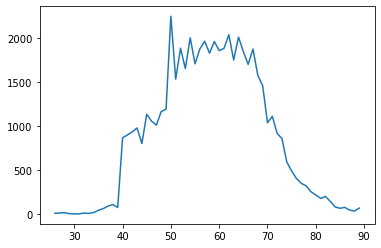

In [14]:
data.age.value_counts().sort_index().plot()

In [15]:
birads_categories = data.BIRADS.cat
data.BIRADS = birads_categories.codes.astype("int64")

In [16]:
density_categories = data.density.cat
data.density = density_categories.codes.astype("int64")

In [17]:
data.dtypes

site_id                     string
patient_id                  string
image_id                    string
laterality                  string
view                        string
age                        float64
cancer                       int64
biopsy                       int64
invasive                     int64
BIRADS                       int64
implant                      int64
density                      int64
machine_id                  string
difficult_negative_case      int64
dtype: object

In [18]:
data.apply(pd.Series.unique, axis=0)

site_id                                                               [2, 1]
patient_id                 [10006, 10011, 10025, 10038, 10042, 10048, 100...
image_id                   [462822612, 1459541791, 1864590858, 1874946579...
laterality                                                            [L, R]
view                                              [CC, MLO, ML, LM, AT, LMO]
age                        [61.0, 55.0, 75.0, 60.0, 51.0, 62.0, 52.0, 67....
cancer                                                                [0, 1]
biopsy                                                                [0, 1]
invasive                                                              [0, 1]
BIRADS                                                         [-1, 0, 1, 2]
implant                                                               [0, 1]
density                                                     [-1, 2, 3, 1, 0]
machine_id                     [29, 21, 216, 93, 49, 48, 170, 210, 190, 197]

In [19]:
data.columns[data.isnull().sum() != 0]

Index(['age'], dtype='object')

In [20]:
data.insert(loc=0, 
            column="image_name", 
            value=(data.site_id + "_" + data.machine_id + "_" + 
                   data.patient_id + "_" + data.image_id + "_" + 
                   data.laterality + "_" + data.view).to_list())

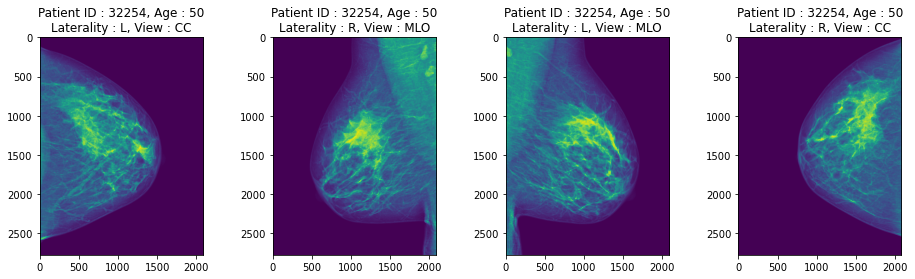

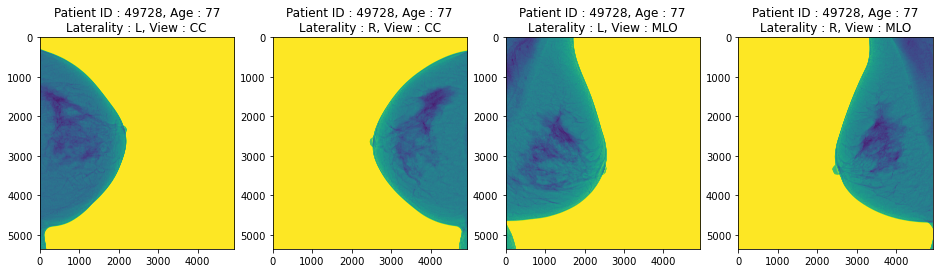

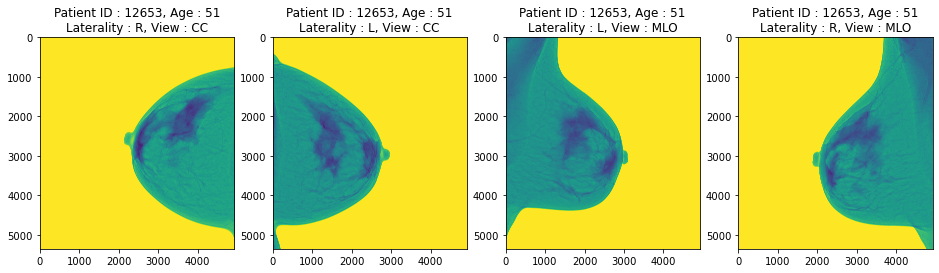

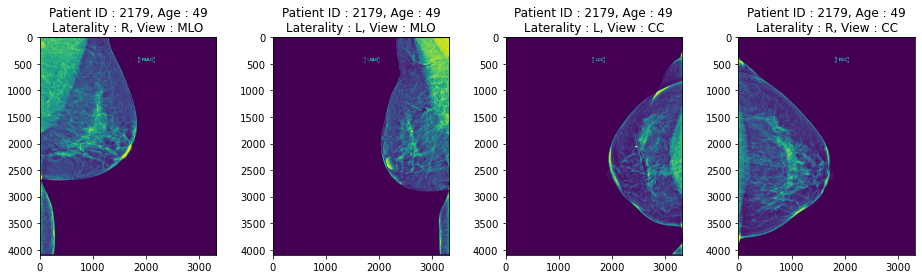

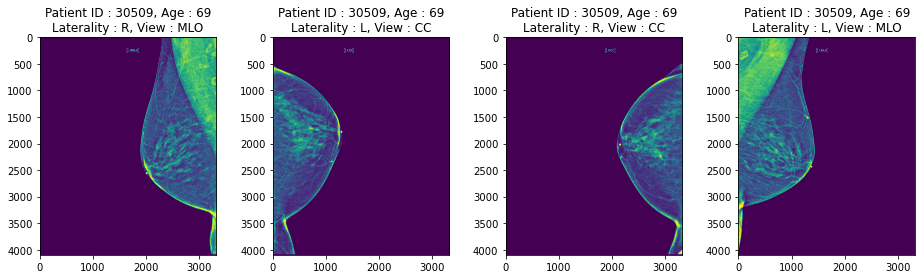

In [21]:
for patient in data.patient_id.sample(n=5, random_state=10):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    patient_path = os.path.join(DATA_HOME_TRAIN, patient)
    for i, image in enumerate(os.listdir(patient_path)):
        dicom = dcmread(os.path.join(patient_path, image))
        dicom_np = dicom.pixel_array
        dicom_norm = normalize(dicom_np)
        ax[i].imshow(dicom_norm)
        dicom_row = data[data.image_id == dicom.InstanceNumber.original_string].squeeze()
        ax[i].title.set_text("Patient ID : {patient}, Age : {age}\nLaterality : {laterality}, View : {view}"
                             .format(patient=dicom_row["patient_id"], 
                                     age=int(dicom_row["age"]), 
                                     laterality=dicom_row["laterality"], 
                                     view=dicom_row["view"]))

In [22]:
data_diversity = pd.DataFrame()
for machine_view in data.loc[:, ["machine_id", "view"]].drop_duplicates().itertuples(index=False):
    mv_row = data[(data.machine_id == machine_view.machine_id) & (data.view == machine_view.view)].sample(n=1)
    dcm = dcmread(os.path.join(DATA_HOME_TRAIN, mv_row.patient_id.iloc[0], mv_row.image_id.iloc[0] + ".dcm")).pixel_array
    mv_row["image_shape"] = [dcm.shape]
    mv_row["image_ar"] = [round(dcm.shape[0] / dcm.shape[1], 3)]
    mv_row["image_range"] = [(dcm.min(), dcm.max())]
    data_diversity = data_diversity.append(mv_row)
data_diversity

,image_name,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_shape,image_ar,image_range
37221,2_29_49943_1831875882_R_CC,2,49943,1831875882,R,CC,50.0,0,0,0,-1,0,-1,29,0,"(5355, 4915)",1.090,"(1313, 3396)"
22572,2_29_34001_1460725288_L_MLO,2,34001,1460725288,L,MLO,72.0,0,0,0,-1,0,-1,29,0,"(5355, 4915)",1.090,"(1241, 3556)"
38143,2_21_50958_1762018204_R_CC,2,50958,1762018204,R,CC,62.0,0,0,0,-1,0,-1,21,0,"(2776, 2082)",1.333,"(0, 3322)"
11894,2_21_22706_1807174290_L_MLO,2,22706,1807174290,L,MLO,63.0,0,0,0,-1,0,-1,21,0,"(2776, 2082)",1.333,"(0, 4093)"
49481,1_216_63388_932209985_L_MLO,1,63388,932209985,L,MLO,43.0,0,0,0,1,0,3,216,0,"(2294, 1914)",1.199,"(0, 2811)"
13595,1_216_24599_1946658043_L_CC,1,24599,1946658043,L,CC,57.0,0,0,0,1,0,2,216,0,"(2294, 1914)",1.199,"(509, 4095)"
31987,1_93_44250_648879738_L_CC,1,44250,648879738,L,CC,76.0,0,0,0,0,0,2,93,1,"(3062, 2394)",1.279,"(108, 3046)"
38144,1_93_5096_192811164_L_MLO,1,5096,192811164,L,MLO,43.0,0,0,0,2,0,1,93,0,"(3062, 2394)",1.279,"(0, 4095)"
17220,1_49_28230_1902509628_R_CC,1,28230,1902509628,R,CC,62.0,0,0,0,1,0,1,49,0,"(4096, 3328)",1.231,"(0, 4095)"
22447,1_49_33897_322533645_L_MLO,1,33897,322533645,L,MLO,68.0,0,0,0,1,0,1,49,0,"(4096, 3328)",1.231,"(0, 4095)"


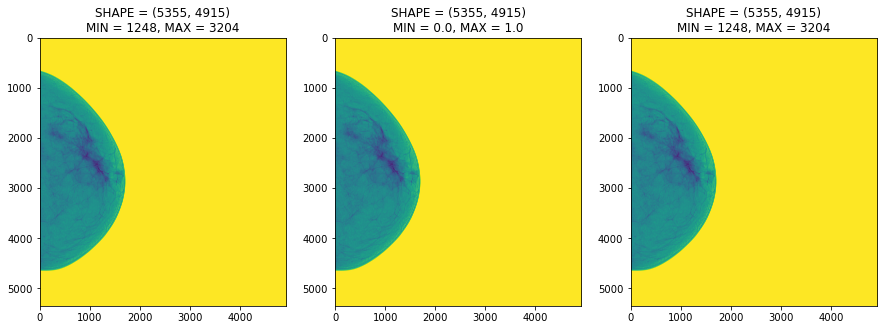

In [23]:
rand = data.loc[:, ["patient_id", "image_id"]].sample(1, random_state=2)
img = dcmread(DATA_HOME_TRAIN + 
              rand.patient_id.iloc[0] + "/" + 
              rand.image_id.iloc[0] + ".dcm").pixel_array

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].title.set_text("SHAPE = {shape}\nMIN = {min}, MAX = {max}".format(shape=img.shape, 
                                                                        min=img.min(), 
                                                                        max=img.max()))
norm = normalize(img)
ax[1].imshow(norm)
ax[1].title.set_text("SHAPE = {shape}\nMIN = {min}, MAX = {max}".format(shape=norm.shape, 
                                                                        min=norm.min(), 
                                                                        max=norm.max()))
crop = crop_by_max_contour(img)
ax[2].imshow(crop)
ax[2].title.set_text("SHAPE = {shape}\nMIN = {min}, MAX = {max}".format(shape=crop.shape, 
                                                                        min=crop.min(), 
                                                                        max=crop.max()))
plt.show()